# Causal Inference with Quasi (Natural) Experiments

Thus far, we have examined methods that are typically associated with estimating the average treatment effect for experimental data. With experimental data, randomness is introduced via treatment assignment. In constrast, with a natural experiment (quasi-experimental data), randomness is introduced via some factors that make it appear as if the treatment were randomly assigned.


## Regression Discontinuity

One common way that this type of randomness is introduced is when treatment is only applied when some observable covariate crosses a threshold. For example, a patient in a hospital may receive a certain medication only when their blood pressure drops below some critical threshold. The **Regression Discontinuity** estimator leverages the variation induced at this boundary in order estimate an average effect of the treatment. The general idea is that individuals very close to the cutoff value are likely to be very similar, so there is a natural matching between the treatment group (those just above the threshold) and the control group (those just below the threshold).

Considering our class size example again, let's assume that small class sizes are no longer randomly assigned, but rather, arise naturally because of a school policy that any classroom with more than 23 students must be split in half. Students are randomly assigned classrooms, so those are ultimately sub-divided are random. Any jump in test scores for classrooms that are split relative to those that just missed the split can reasonably be attributed to the effect of the smaller class size. We can estimate the size of this discontinuity using standard OLS with an indicator variable at the threshold. Because all classrooms below the threshold are not split and all above the theshold are split, this is referred to as a **sharp regression discontinuity** design.

### Sharp Regression Discontinuity

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from scipy.linalg import cholesky
from sklearn.preprocessing import minmax_scale, scale

np.random.seed(12345)
%matplotlib inline

In [2]:
population_size = 5000
threshold = 24
possible_class_sizes = np.arange(16, 31, 1)
original_class_sizes = np.random.choice(possible_class_sizes, population_size)\

# Simulate split classrooms
actual_class_sizes = np.array([int(round(n / 2)) if n >= threshold else n for n in original_class_sizes])
split_class = np.array([1 if n >= threshold else 0 for n in original_class_sizes])

treatment_effect = 10
population_scores = 75 + treatment_effect*split_class + np.random.normal(loc=0.0, scale=5.0, size=population_size)

# Plot the distribution
treatment_df = pd.DataFrame()
treatment_df["orig_class_size"] = original_class_sizes
treatment_df["actual_class_size"] = actual_class_sizes
treatment_df["split_class"] = treatment_df["orig_class_size"] >= threshold
treatment_df["pop_reg_line"] = 75 + treatment_effect*treatment_df["split_class"]
treatment_df["score"] = population_scores

treatment_df.head()

,orig_class_size,actual_class_size,split_class,pop_reg_line,score
0,18,18,False,75,65.010300
1,21,21,False,75,77.871838
2,29,14,True,85,92.655889
3,17,17,False,75,74.401112
4,20,20,False,75,72.106394


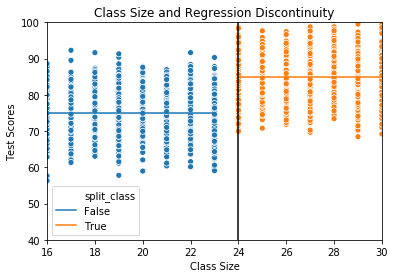

In [3]:
fig, ax = plt.subplots()
sns.lineplot(x="orig_class_size", 
             y="pop_reg_line", 
             hue="split_class", 
             data=treatment_df, 
             ax=ax)
sns.scatterplot(x="orig_class_size", 
                y="score", 
                hue="split_class", 
                data=treatment_df, 
                estimator=None, 
                ax=ax, 
                legend=False)

ax.axvline(threshold, 0, 1, color="black")
ax.set_xlim(16, 30)
ax.set_ylim(40, 100)
ax.set_xlabel("Class Size")
ax.set_ylabel("Test Scores")
ax.set_title("Class Size and Regression Discontinuity")
plt.savefig("./images/sharp_rd_class_size.png", dpi=300)

In [4]:
model = smf.ols(formula="score ~ 1 + split_class", data=treatment_df)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.490
Model:                            OLS   Adj. R-squared:                  0.490
Method:                 Least Squares   F-statistic:                     4796.
Date:                Sat, 06 Jul 2019   Prob (F-statistic):               0.00
Time:                        21:20:18   Log-Likelihood:                -15202.
No. Observations:                5000   AIC:                         3.041e+04
Df Residuals:                    4998   BIC:                         3.042e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              74.9652      0.098    768.248      0.000      74.774      75.157
split_class[T.True]     9.9439      0.144     69.251      0.000       9.662      10.225
==============================================================================
Omnibus:                        0.633   Durbin-Watson:                   1.973
Prob(Omnibus):                  0.729   Jarque-Bera (JB):                0.580
Skew:                          -0.008   Prob(JB):                        0.748
Kurtosis:                       3.050   Cond. No.                         2.54
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Including a dummy variable (split class) that captures the discontinuity of interest allows standard OLS to be able to recover the simulated ATE of 10 points. Although the current example was constructed such that any split classroom resulted in a 10 point bump in test scores, the same process could be used if the treatment effect was directly proportional to the size of the class. Can you modify the code above to simulate a treatment effect where each additional student causes average test scores to fall by 0.5? What parts of the code would need to change? What is the new estimated ATE?

### Fuzzy Regression Discontinuity

Now, let's consider the situation where the threshold of interest merely increases the probability of receiving treatment. This is referred to as a  **fuzzy regression discontinuity** design. To get an unibased estimate of the ATE, we use the threshold as a instrumental variable for the actual treatment received. Think back to the previous notebook. Does this proposed instrument satisify the two criteria for a valid instrument (relevance and exogeneity)?

Since crossing the threshold increases the probability of receiviung treatment, the endogeneous variable (treatment) and the proposed instrument are clearly correlated. Secondly, if the only effect of crossing the treshold is to increase the probability of receiving treatment (no other unobserved or observed covariates are affected), then the exogeneity requirement is also satisfied.

We will use the same hypothetical scenario as before. Now, instead of crossing the threshold guaranteeing that the class will be split, the classroom will only become a candidate for splitting. Since there are a limited number of teachers available, all classes that would ideally be split cannot be, so classes are chosen partially at random to be split.

In [5]:
sample_size = 5000

corr_mat = np.array([
    [1.0, 0.8],
    [0.8, 1.0]
])

upper_cholesky = cholesky(corr_mat)
random_data = np.random.normal(0, 1, size=(sample_size, 2))
transformed_data = random_data @ upper_cholesky

candidate_split_class = minmax_scale(transformed_data[:, 0], feature_range=(0,1))
candidate_split_class = [1 if s > 0.5 else 0 for s in candidate_split_class]

split_class = minmax_scale(transformed_data[:, 1] ,feature_range=(0,1))
split_class = np.array([1 if s > np.median(split_class) else 0 for s in split_class])

treatment_effect = 10
sample_scores = 75 + treatment_effect*split_class + np.random.normal(loc=0.0, scale=5.0, size=population_size)

# Plot the distribution
treatment_df = pd.DataFrame()
treatment_df["oversized_class"] = candidate_split_class
treatment_df["split_class"] = split_class
treatment_df["score"] = sample_scores

treatment_df.head()

,oversized_class,split_class,score
0,0,0,71.285707
1,0,0,73.497769
2,0,1,93.733033
3,0,0,69.531846
4,0,0,68.858711


In [6]:
first_stage_model = smf.ols(formula="split_class ~ 1 + oversized_class", data=treatment_df)
first_stage_result = first_stage_model.fit()
first_stage_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            split_class   R-squared:                       0.345
Model:                            OLS   Adj. R-squared:                  0.345
Method:                 Least Squares   F-statistic:                     2630.
Date:                Sat, 06 Jul 2019   Prob (F-statistic):               0.00
Time:                        21:20:19   Log-Likelihood:                -2571.9
No. Observations:                5000   AIC:                             5148.
Df Residuals:                    4998   BIC:                             5161.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.2213      0.008     28.035      0.000       0.206       0.237
oversized_class     0.5880      0.011     51.285      0.000       0.566       0.610
==============================================================================
Omnibus:                        7.164   Durbin-Watson:                   2.032
Prob(Omnibus):                  0.028   Jarque-Bera (JB):                7.187
Skew:                           0.080   Prob(JB):                       0.0275
Kurtosis:                       3.096   Cond. No.                         2.56
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Oversized classes appear to be a good instrument for treatment since they explain a fair amount of the variation in treatment and the F-statistic from the first stage is well above the folk-lore threshold of 10.

In [7]:
predicted_values = first_stage_result.predict(treatment_df)
treatment_df["predicted_treatment"] = predicted_values

second_stage_model = smf.ols(formula="score ~ 1 + predicted_treatment", data=treatment_df)
second_stage_result = second_stage_model.fit()
second_stage_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.163
Model:                            OLS   Adj. R-squared:                  0.163
Method:                 Least Squares   F-statistic:                     971.8
Date:                Sat, 06 Jul 2019   Prob (F-statistic):          4.17e-195
Time:                        21:20:19   Log-Likelihood:                -16436.
No. Observations:                5000   AIC:                         3.288e+04
Df Residuals:                    4998   BIC:                         3.289e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              75.1457      0.181    415.281      0.000      74.791      75.500
predicted_treatment     9.7285      0.312     31.173      0.000       9.117      10.340
==============================================================================
Omnibus:                        1.019   Durbin-Watson:                   2.070
Prob(Omnibus):                  0.601   Jarque-Bera (JB):                0.977
Skew:                          -0.001   Prob(JB):                        0.614
Kurtosis:                       3.068   Cond. No.                         4.32
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Differences in Differences 

Up until this point, we have assumed that we have cross-sectional data on our student population of interest. In a realistic experiment where students are randomly assigned to be in a small class versus a normal-sized class, we might be concerned with spillover effects if there are both small classes and large classes in the same school. The students in the small classes will likely interact with the students from the large classes, so it is possible that some of benefit of the small classes may end up benefiting those in large classes via impromptu or unanticipated tutoring across classes. Perhaps it would be better to randomly assign small or large classes at the _school_ level. Now, we have a different dilemma. What if there are fundamental differences between the schools? With a single cross-section of data, there really isn't anything we can do. But, if we have pre-treatment data on both schools, then it is possible for us to isolate out the fixed differences between the schools to avoid having a biased estimate for the average treatment effect.

To account for these pre-treatment differences, we can make a slight tweak to the standard multiple regression set up and achieve our desired estimate. Instead of using test scores as the independent variable, we instead use the change in test scores from before treatment to after treatment. This is the **difference in differences** estimator.

In [8]:
population_size = 5000
treatment = np.random.choice([0, 1], size=population_size)

treatment_effect = 10
worse_school_effect = 3

baseline_scores = (75 
                   - worse_school_effect*treatment 
                   + np.random.normal(loc=0.0, scale=5.0, size=population_size))

population_scores = (75 
                     + treatment_effect*treatment 
                     - worse_school_effect*treatment 
                     + np.random.normal(loc=0.0, scale=5.0, size=population_size))

# Plot the distribution
treatment_df = pd.DataFrame()
treatment_df["treatment"] = treatment
treatment_df["post_treatment_score"] = population_scores
treatment_df["pre_treatment_score"] = baseline_scores
treatment_df["score_change"] = treatment_df["post_treatment_score"] - treatment_df["pre_treatment_score"]

treatment_df.head()

,treatment,post_treatment_score,pre_treatment_score,score_change
0,1,78.441980,68.669205,9.772775
1,0,71.194219,76.129785,-4.935566
2,0,70.631354,72.975376,-2.344022
3,1,80.575854,62.295871,18.279983
4,1,86.156706,76.768238,9.388468


In [9]:
# Naive Method: Ignore School Differences
model = smf.ols(formula="post_treatment_score ~ 1 + treatment", data=treatment_df)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     post_treatment_score   R-squared:                       0.355
Model:                              OLS   Adj. R-squared:                  0.354
Method:                   Least Squares   F-statistic:                     2745.
Date:                  Sat, 06 Jul 2019   Prob (F-statistic):               0.00
Time:                          21:20:19   Log-Likelihood:                -15059.
No. Observations:                  5000   AIC:                         3.012e+04
Df Residuals:                      4998   BIC:                         3.014e+04
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     74.9167      0.098    763.053      0.000      74.724      75.109
treatment      7.2897      0.139     52.396      0.000       7.017       7.562
==============================================================================
Omnibus:                        2.293   Durbin-Watson:                   1.973
Prob(Omnibus):                  0.318   Jarque-Bera (JB):                2.313
Skew:                           0.039   Prob(JB):                        0.315
Kurtosis:                       2.929   Cond. No.                         2.61
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

As expected, the systematic differences between the treated and untreated students due to school differences was swallowed up into the estimated coefficient for the effect of the treatment, biasing it downward.

In [10]:
model = smf.ols(formula="score_change ~ 1 + treatment", data=treatment_df)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           score_change   R-squared:                       0.345
Model:                            OLS   Adj. R-squared:                  0.345
Method:                 Least Squares   F-statistic:                     2632.
Date:                Sat, 06 Jul 2019   Prob (F-statistic):               0.00
Time:                        21:20:19   Log-Likelihood:                -16900.
No. Observations:                5000   AIC:                         3.380e+04
Df Residuals:                    4998   BIC:                         3.382e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0615      0.142     -0.434      0.665      -0.340       0.217
treatment     10.3130      0.201     51.299      0.000       9.919      10.707
==============================================================================
Omnibus:                        0.123   Durbin-Watson:                   2.017
Prob(Omnibus):                  0.940   Jarque-Bera (JB):                0.106
Skew:                           0.010   Prob(JB):                        0.948
Kurtosis:                       3.009   Cond. No.                         2.61
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Nice, simply changing the outcome measure that we are modeling had exactly the effect that we anticipated.

### Alternative Specification

We can achieve an identical result using a slightly different specification. We can continue to use the post-treatment test scores as our outcome variable so long as we add an indicator variable for if an observation came from the post-treatment period and an interaction between the treatment variable and this time dummy.



In [11]:
pre_treatment_df = pd.DataFrame()
pre_treatment_df["treatment"] = treatment
pre_treatment_df["score"] = baseline_scores
pre_treatment_df["post_treatment"] = 0


post_treatment_df = pd.DataFrame()
post_treatment_df["treatment"] = treatment
post_treatment_df["score"] = population_scores
post_treatment_df["post_treatment"] = 1

treatment_df = pd.concat([pre_treatment_df, post_treatment_df], axis=0)
treatment_df.head()


,treatment,score,post_treatment
0,1,68.669205,0
1,0,76.129785,0
2,0,72.975376,0
3,1,62.295871,0
4,1,76.768238,0


In [12]:
model = smf.ols(formula="score ~ 1 + treatment*post_treatment", data=treatment_df)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.368
Model:                            OLS   Adj. R-squared:                  0.367
Method:                 Least Squares   F-statistic:                     1937.
Date:                Sat, 06 Jul 2019   Prob (F-statistic):               0.00
Time:                        21:20:19   Log-Likelihood:                -30176.
No. Observations:               10000   AIC:                         6.036e+04
Df Residuals:                    9996   BIC:                         6.039e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   74.9782      0.099    759.234      0.000      74.785      75.172
treatment                   -3.0233      0.140    -21.604      0.000      -3.298      -2.749
post_treatment              -0.0615      0.140     -0.441      0.660      -0.335       0.212
treatment:post_treatment    10.3130      0.198     52.110      0.000       9.925      10.701
==============================================================================
Omnibus:                        0.598   Durbin-Watson:                   2.017
Prob(Omnibus):                  0.742   Jarque-Bera (JB):                0.629
Skew:                           0.003   Prob(JB):                        0.730
Kurtosis:                       2.961   Cond. No.                         6.84
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

With the alternative specification, we can see that the point estimate for the treatment effect (treatment:post_treatment) and standard error are identical to the prior specification. Although it is outside the scope of this notebook, this is actually a nice lead-in to a generalization of the difference in differences estimator. For a small preview, consider extending the current analysis that has two time periods to data with T time periods. We could update our model to include T-1 indicator variables for time and would arrive at **fixed effects** model.

## Matching (Propensity Score Matching)

Whole purpose is to estimate an ATE from observational data (or failed randomization), i.e. data that has selection bias.